In [1]:
%matplotlib inline
import sys
import psycopg2
import psycopg2.extras
import numpy
import pandas
from matplotlib import pyplot

In [2]:
# Read scanscore into memory for further processing
with open("/global/homes/r/raknop/secrets/decatdb_decat_decat") as ifp:
    (user, passwd) = ifp.readline().strip().split()
db = psycopg2.connect(f"dbname='decat' user='{user}' password='{passwd}' host='decatdb.lbl.gov'",
                      cursor_factory=psycopg2.extras.RealDictCursor)
q = ( 'SELECT s.id,s.object_id,s.username,s.goodbad,o.rb '
      'FROM scanscore s '
      'INNER JOIN objects o ON s.object_id=o.id '
      'ORDER BY s.object_id' )
cursor = db.cursor()
cursor.execute(q)
scanscore = pandas.DataFrame( cursor.fetchall() )
cursor.close()
db.close()

In [3]:
# Show how many objects each user has vetted
tots = scanscore.groupby(['username','goodbad'])['object_id'].count()
tots = tots.groupby(['username']).agg( num='sum',
                                       good_frac=lambda row: row[row.index[1][1]=="good"] / row.sum() )
tots = tots.sort_values( 'num', ascending=False )
print(tots)


            num  good_frac
username                  
rknop     25540   0.188802
ruby      25400   0.101181
autumn    24760   0.166559
alexis    16110   0.099131
caitlin    3495   0.152217
penugent   2145   0.111422
tkennedy    608   0.238487


In [4]:
# Show stats on how many times a given object has been vetted
print( scanscore.groupby(['object_id'])['username'].count().reset_index(name='#vets')
       .groupby(['#vets'])['object_id'].count().reset_index(name="count") )

   #vets  count
0      1  13571
1      2  16645
2      3  11646
3      4   3532
4      5    401
5      6     21


In [5]:
# Show counts of num goods and num bads.  Not terribly meaningful by itself, we
#   really need to do cross counts
print( scanscore.groupby( ['object_id', 'goodbad'] )['object_id'].count().reset_index(name='num')
       .groupby( ['goodbad', 'num'] )['num'].count().reset_index(name='count') )

   goodbad  num  count
0      bad    1  14935
1      bad    2  14980
2      bad    3   9092
3      bad    4   2610
4      bad    5    268
5      bad    6     13
6     good    1   5751
7     good    2   2559
8     good    3    812
9     good    4    161
10    good    5     16


In [6]:
# Create a table where each row is one object, that has username and goodbad as lists
# This takes a few seconds
objtable = ( scanscore.groupby( ['object_id', 'rb'] )["username", "goodbad"]
               .agg( tuple ) )
objtable["ngood"] = objtable["goodbad"].apply( lambda x: ( numpy.array( x ) == "good" ).sum() )
objtable["nbad"] = objtable["goodbad"].apply( lambda x: ( numpy.array( x ) == "bad" ).sum() )
objtable.reset_index(inplace=True)

In [7]:
print(objtable)

       object_id        rb               username          goodbad  ngood  \
0             63  0.000034          (rknop, ruby)       (bad, bad)      0   
1            101  0.000059                (ruby,)           (bad,)      0   
2            162  0.000077  (rknop, ruby, alexis)  (bad, bad, bad)      0   
3            258  0.007573  (rknop, ruby, alexis)  (bad, bad, bad)      0   
4            327  0.001489                (ruby,)           (bad,)      0   
...          ...       ...                    ...              ...    ...   
45811   11233910  0.005098                (ruby,)           (bad,)      0   
45812   11235735  0.000453               (rknop,)           (bad,)      0   
45813   11236973  0.037404               (rknop,)           (bad,)      0   
45814   11241315  0.080948               (rknop,)          (good,)      1   
45815   11246471  0.000144          (rknop, ruby)       (bad, bad)      0   

       nbad  
0         2  
1         1  
2         3  
3         3  
4    

In [8]:
print( objtable.columns )

Index(['object_id', 'rb', 'username', 'goodbad', 'ngood', 'nbad'], dtype='object')


In [9]:
# Show consistency stats
maxgood = objtable['ngood'].max()
maxbad = objtable['nbad'].max()
print( f'{"nbad":>6s} |', end='' )
for j in range(maxbad+1):
    print( f' {j:5d} |', end='' )
print('\nngood  |', end='')
for j in range(maxbad+1):
    print( '       |', end='')
print('\n-------|', end='')
for j in range(maxbad+1):
    print( '-------|', end='')
print('')
for i in range(maxgood+1):
    print( f' {i:5d} |', end='' )
    for j in range(maxbad+1):
        n = ( ( objtable['ngood'] == i ) & ( objtable['nbad'] == j ) ).sum()
        print( f' {n:5} |', end='' )
    print('\n-------|', end='')
    for j in range(maxbad+1):
        print( '-------|', end='')
    print('')

  nbad |     0 |     1 |     2 |     3 |     4 |     5 |     6 |
ngood  |       |       |       |       |       |       |       |
-------|-------|-------|-------|-------|-------|-------|-------|
     0 |     0 | 11744 | 13244 |  8687 |  2562 |   267 |    13 |
-------|-------|-------|-------|-------|-------|-------|-------|
     1 |  1827 |  2051 |  1446 |   379 |    47 |     1 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     2 |  1350 |   919 |   265 |    24 |     1 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     3 |   594 |   193 |    23 |     2 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     4 |   133 |    26 |     2 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     5 |    14 |     2 |     0 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|


In [10]:
# A function to add stats for a given user
def adduserstats( objtable, user ):
    if f"{user}_good" in objtable.columns:
        return
    sys.stderr.write( f"Adding isgood/isbad for {user}...\n" )
    def isgoodbad( row, user, goodbad ):
        dex = numpy.where(numpy.array( row["username"], ndmin=1 ) == user)[0]
        if dex.size == 0:
            return False
        else:
            return numpy.array( row["goodbad"], ndmin=1)[dex[0]] == goodbad
    objtable[f"{user}_good"] = objtable.apply( lambda row: isgoodbad(row, user, "good"), axis=1)
    objtable[f"{user}_bad"] = objtable.apply( lambda row: isgoodbad(row, user, "bad"), axis=1)
    sys.stderr.write( f"...done adding isgood/isbad for {user}.\n" )
    sys.stderr.flush()
    
# A function to print user stats
def userstats( objtable, user ):
    adduserstats( objtable, user )
    goodtable = objtable[ objtable[f"{user}_good"] ].groupby( [ f"ngood", f"nbad"] )["username"].count()
    print( f"Ratings for objects that {user} rated good:" )
    print( goodtable )
    badtable = objtable[ objtable[f"{user}_bad"] ].groupby( [f"ngood", f"nbad"] )["username"].count()
    print( f"Ratings for objects that {user} rated bad:" )
    print( badtable )
    
# A function to compare two users
def compareusers( objtable, user1, user2 ):
    adduserstats( objtable, user1 )
    adduserstats( objtable, user2 )
    goodgood = ( objtable[f"{user1}_good"] & objtable[f"{user2}_good"] ).sum()
    goodbad =  ( objtable[f"{user1}_good"] & objtable[f"{user2}_bad"] ).sum()
    badgood =  ( objtable[f"{user1}_bad"] & objtable[f"{user2}_good"] ).sum()
    badbad =   ( objtable[f"{user1}_bad"] & objtable[f"{user2}_bad"] ).sum()
    
    print( f'{user1:>8s} |   good   |    bad   |' )
    print( f'{user2:<8s} |          |          |' )
    print( f'---------------------------------' )
    print( f'good     |   {goodgood:4d}   |   {badgood:4d}   |' )
    print( f'---------------------------------' )
    print( f'bad      |   {goodbad:4d}   |   {badbad:4d}   |' )
    print( f'---------------------------------' )

# Compare user to majority
def uservsmajority( objtable, user, minrates=2, mindiff=2 ):
    adduserstats( objtable, user )
    goodtable = objtable[ ( objtable["ngood"]-objtable["nbad"] >= mindiff ) &
                          ( objtable["ngood"]+objtable["nbad"] >= minrates ) ]
    badtable = objtable[ ( objtable["nbad"]-objtable["ngood"] >= mindiff ) &
                         ( objtable["nbad"]+objtable["ngood"] >= minrates ) ]
    goodgood = ( goodtable[f"{user}_good"] ).sum()
    goodbad = ( goodtable[f"{user}_bad"] ).sum()
    badgood = ( badtable[f"{user}_good"] ).sum()
    badbad = ( badtable[f"{user}_bad"] ).sum()
    
    print( f'{user} vs. majority (diff≥{mindiff}, n.rates≥{minrates})' )
    print( f' majority|   good   |    bad   |' )
    print( f'{user:<8s} |          |          |' )
    print( f'---------------------------------' )
    print( f'good     |   {goodgood:4d}   |   {badgood:4d}   |' )
    print( f'---------------------------------' )
    print( f'bad      |   {goodbad:4d}   |   {badbad:4d}   |' )
    print( f'---------------------------------' )


In [11]:
userstats( objtable, "rknop" )

Adding isgood/isbad for rknop...
...done adding isgood/isbad for rknop.


Ratings for objects that rknop rated good:
ngood  nbad
1      0       322
       1       905
       2       744
       3       166
       4        19
       5         1
2      0       921
       1       669
       2       193
       3        14
       4         1
3      0       509
       1       168
       2        17
       3         2
4      0       129
       1        25
       2         2
5      0        13
       1         2
Name: username, dtype: int64
Ratings for objects that rknop rated bad:
ngood  nbad
0      1       1443
       2       8165
       3       7146
       4       2391
       5        264
       6         13
1      1        422
       2        463
       3        186
       4         26
2      1        113
       2         54
       3          8
3      1         17
       2          6
4      1          1
Name: username, dtype: int64


In [12]:
compareusers( objtable, "rknop", "penugent" )

Adding isgood/isbad for penugent...
...done adding isgood/isbad for penugent.


   rknop |   good   |    bad   |
penugent |          |          |
---------------------------------
good     |    111   |     41   |
---------------------------------
bad      |    165   |   1031   |
---------------------------------


In [13]:
uservsmajority( objtable, "rknop", minrates=1, mindiff=2 )

rknop vs. majority (diff≥2, n.rates≥1)
 majority|   good   |    bad   |
rknop    |          |          |
---------------------------------
good     |   1769   |    187   |
---------------------------------
bad      |     18   |   18191   |
---------------------------------


In [14]:
# Make a histogram of rb scores
def histrb( objtable, mode="unanimous", user=None, minrates=2, mindiff=2, ylog=True, ylinmax=5000 ):
    if mode == "user":
        if user is None:
            raise ValueError( "Must specify user for mode user" )
        adduserstats( objtable, user )
        bads = objtable[ objtable[f"{user}_bad"] ]
        goods = objtable[ objtable[f"{user}_good"] ]
        title = f"{user} rankings"
    elif mode == "unanimous":
        bads = objtable[ ( objtable["ngood"] == 0 ) & ( objtable["nbad"] >= minrates ) ]
        goods = objtable[ ( objtable["ngood"] >= minrates ) & ( objtable["nbad"] == 0 ) ]
        title = f"Unanimous vetting with at least {minrates} rankings"
    elif mode =="majority":
        bads = objtable[ ( objtable["nbad"]-objtable["ngood"] >= mindiff ) &
                         ( objtable["nbad"]+objtable["ngood"] >= minrates ) ]
        goods = objtable[ ( objtable["ngood"]-objtable["nbad"] >= mindiff ) &
                          ( objtable["ngood"]+ objtable["nbad"] >= minrates ) ]
        title = f"Majority vetting w/ ≥{minrates} ratings and difference ≥ {mindiff}"
    else:
        raise ValueError( f"Unknown mode {mode}" )
    goodrb = goods["rb"].values
    badrb = bads["rb"].values
    # Have to do the range to 1.1 because numpy.hist doesn't count the right edge,
    #  and we definitely want to include rb=1.0
    bins = numpy.arange( 0., 1.2, 0.1 )
    goodhist, junk = numpy.histogram( goodrb, bins )
    badhist, junk = numpy.histogram( badrb, bins )
    fig = pyplot.figure( figsize=(10,6), tight_layout=True )
    ax = fig.add_subplot( 1, 1, 1 )
    if ylog:
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, ylinmax)
    ax.set_title( title, fontsize=18 )
    ax.set_xlabel( 'rb', fontsize=18 )
    ax.set_ylabel( 'N', fontsize=18 )
    ax.tick_params( axis='both', labelsize=16 )
    ax.step( bins[:-1], goodhist, color='b', where="post" )
    ax.step( bins[:-1], badhist, color='r', where="post" )
    fig.show()
    return fig

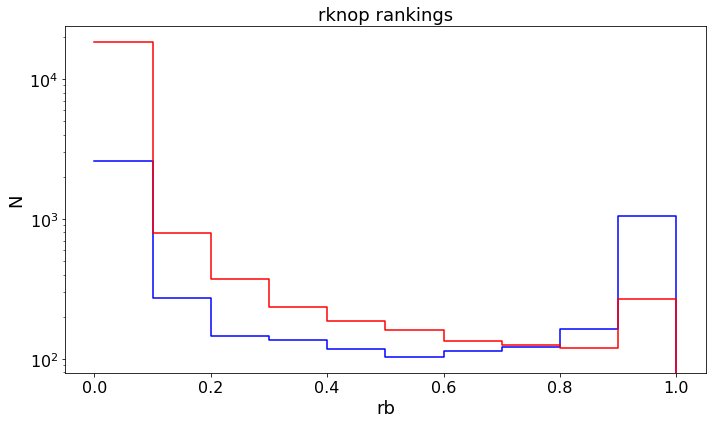

In [15]:
fig = histrb( objtable, mode="user", user="rknop", minrates=2, mindiff=2, ylog=True, ylinmax=1500 )
fig.savefig( "vettingvsrb.svg" )